In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

Using TensorFlow backend.


### Load data

In [2]:
train = pd.read_csv('../input/X_train.csv')
labels = pd.read_csv('../input/y_train.csv')
test = pd.read_csv('../input/X_test.csv').sort_values(['series_id', 'measurement_number'])

### Join train features with labels

In [3]:
train = pd.merge(train, labels, how='inner').sort_values(['series_id', 'measurement_number'])
print(train.shape)
display(train.head())
display(train.describe().T)

(487680, 15)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


,count,mean,std,min,25%,50%,75%,max
series_id,487680.0,1904.500000,1099.853353,0.00000,952.000000,1904.500000,2857.000000,3809.00000
measurement_number,487680.0,63.500000,36.949327,0.00000,31.750000,63.500000,95.250000,127.00000
orientation_X,487680.0,-0.018050,0.685696,-0.98910,-0.705120,-0.105960,0.651803,0.98910
orientation_Y,487680.0,0.075062,0.708226,-0.98965,-0.688980,0.237855,0.809550,0.98898
orientation_Z,487680.0,0.012458,0.105972,-0.16283,-0.089466,0.031949,0.122870,0.15571
orientation_W,487680.0,-0.003804,0.104299,-0.15662,-0.106060,-0.018704,0.097215,0.15477
angular_velocity_X,487680.0,0.000178,0.117764,-2.37100,-0.040752,0.000084,0.040527,2.28220
angular_velocity_Y,487680.0,0.008338,0.088677,-0.92786,-0.033191,0.005412,0.048068,1.07910
angular_velocity_Z,487680.0,-0.019184,0.229153,-1.26880,-0.090743,-0.005335,0.064604,1.38730
linear_acceleration_X,487680.0,0.129281,1.870600,-36.06700,-0.530833,0.124980,0.792263,36.79700


### Turn data into series

In [4]:
def series_to_supervised(data, features, window=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data[features].shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in features]
    # Current timestep (t=0)
    cols.append(data)
    names += [(col) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [5]:
window = 5
features = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 
            'series_id']
use_cols = features + ['surface']
# Train
train_series = series_to_supervised(train[use_cols], features, window=window)
train_series.dropna(inplace=True)        
train_series = train_series[(train_series['series_id'] == train_series['series_id(t-%s)' % window])]
display(train_series.head())

# Test
test_series = series_to_supervised(test[features], features, window=window)
test_series.fillna(test_series.mean(), inplace=True)
# Backwards inputation
for index, row in test_series.iterrows():
    for i in range(1, window+1):
        if row['series_id'] != row['series_id(t-%s)' % i]:
            for feature in features:
                if feature != 'series_id':
                    test_series.at[index, '%s(t-%s)' % (feature, i)] = row[feature]
display(test_series.head())

,angular_velocity_X(t-5),angular_velocity_Y(t-5),angular_velocity_Z(t-5),linear_acceleration_X(t-5),linear_acceleration_Y(t-5),linear_acceleration_Z(t-5),series_id(t-5),angular_velocity_X(t-4),angular_velocity_Y(t-4),angular_velocity_Z(t-4),linear_acceleration_X(t-4),linear_acceleration_Y(t-4),linear_acceleration_Z(t-4),series_id(t-4),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),series_id(t-3),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),series_id(t-2),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),series_id(t-1),angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,series_id,surface
5,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.0,0.067851,0.029939,0.003385,0.33995,1.50640,-9.4128,0.0,0.007275,0.028934,-0.005978,-0.26429,1.59220,-8.7267,0.0,-0.013053,0.019448,-0.008974,0.42684,1.099300,-10.0960,0.0,0.005135,0.007652,0.005245,-0.50969,1.468900,-10.4410,0.0,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,0,fine_concrete
6,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.0,0.007275,0.028934,-0.005978,-0.26429,1.59220,-8.7267,0.0,-0.013053,0.019448,-0.008974,0.42684,1.09930,-10.0960,0.0,0.005135,0.007652,0.005245,-0.50969,1.468900,-10.4410,0.0,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,0.0,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296,0,fine_concrete
7,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,0.0,-0.013053,0.019448,-0.008974,0.42684,1.09930,-10.0960,0.0,0.005135,0.007652,0.005245,-0.50969,1.46890,-10.4410,0.0,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,0.0,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296,0.0,0.056218,0.038162,-0.022931,-0.12160,0.075417,-8.6088,0,fine_concrete
8,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,0.0,0.005135,0.007652,0.005245,-0.50969,1.46890,-10.4410,0.0,0.059664,0.013043,-0.013231,-0.44745,0.99281,-10.4020,0.0,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296,0.0,0.056218,0.038162,-0.022931,-0.12160,0.075417,-8.6088,0.0,-0.012846,0.039004,-0.007831,1.60000,0.816110,-7.6426,0,fine_concrete
9,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.0,0.059664,0.013043,-0.013231,-0.44745,0.99281,-10.4020,0.0,0.082140,0.044356,-0.002696,-0.14163,0.73497,-9.4296,0.0,0.056218,0.038162,-0.022931,-0.12160,0.075417,-8.6088,0.0,-0.012846,0.039004,-0.007831,1.60000,0.816110,-7.6426,0.0,-0.090082,0.027299,-0.009970,0.47496,0.909600,-8.8120,0,fine_concrete


,angular_velocity_X(t-5),angular_velocity_Y(t-5),angular_velocity_Z(t-5),linear_acceleration_X(t-5),linear_acceleration_Y(t-5),linear_acceleration_Z(t-5),series_id(t-5),angular_velocity_X(t-4),angular_velocity_Y(t-4),angular_velocity_Z(t-4),linear_acceleration_X(t-4),linear_acceleration_Y(t-4),linear_acceleration_Z(t-4),series_id(t-4),angular_velocity_X(t-3),angular_velocity_Y(t-3),angular_velocity_Z(t-3),linear_acceleration_X(t-3),linear_acceleration_Y(t-3),linear_acceleration_Z(t-3),series_id(t-3),angular_velocity_X(t-2),angular_velocity_Y(t-2),angular_velocity_Z(t-2),linear_acceleration_X(t-2),linear_acceleration_Y(t-2),linear_acceleration_Z(t-2),series_id(t-2),angular_velocity_X(t-1),angular_velocity_Y(t-1),angular_velocity_Z(t-1),linear_acceleration_X(t-1),linear_acceleration_Y(t-1),linear_acceleration_Z(t-1),series_id(t-1),angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,series_id
0,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.480474,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.484379,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.488284,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.49219,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,1907.496095,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0
1,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.480474,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.484379,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.488284,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,1907.49219,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.000000,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0
2,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.480474,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.484379,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1907.488284,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.00000,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.000000,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,0
3,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,1907.480474,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,1907.484379,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.000000,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.00000,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,0.000000,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,0
4,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100,1907.480474,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.000000,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.000000,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,0.00000,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,0.000000,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100,0


### Pre process the labels

In [6]:
target = train_series['surface']
n_labels = target.nunique()
labels_names = target.unique()
le = LabelEncoder()
target = le.fit_transform(target.values)
target = to_categorical(target)
train_series.drop('surface', axis=1, inplace=True)

### Train/validation split

In [7]:
X_train, X_val, Y_train, Y_val = train_test_split(train_series, target, test_size=0.2, random_state=0)
series_cols = list(X_train.filter(regex='series_id'))
X_train.drop(series_cols, axis=1, inplace=True)
X_val.drop(series_cols, axis=1, inplace=True)
test_series.drop(series_cols, axis=1, inplace=True)

### Feature engineering

In [8]:
def agg_features(df):
    df['orientation'] = df['orientation_X'] + df['orientation_Y'] + df['orientation_Z'] + df['orientation_W']
    df['angular_velocity'] = df['angular_velocity_X'] + df['angular_velocity_Y'] + df['angular_velocity_Z']
    df['linear_acceleration'] = df['linear_acceleration_X'] + df['linear_acceleration_Y'] + df['linear_acceleration_Z']
    
# agg_features(X_train)
# agg_features(X_val)
# agg_features(test)

### Mean encoding on categorical features

In [9]:
# features.append('angular_velocity')
# features.append('linear_acceleration')
# mean_enc_features = list(features)

# # By series
# for feature in (features):
#     if feature not in ['series_id', 'measurement_number']:
#         median = '%s_series_mean' % feature
#         std = '%s_series_std' % feature
#         diff = '%s_series_mean_diff' % feature
#         mean_enc_features.append(median)
#         mean_enc_features.append(std)
#         mean_enc_features.append(diff)
#         X_train[median] = X_train['series_id'].map(X_train.groupby('series_id')[feature].mean())
#         X_val[median] = X_val['series_id'].map(X_val.groupby('series_id')[feature].mean())
#         test[median] = test['series_id'].map(test.groupby('series_id')[feature].mean())
        
#         X_train[std] = X_train['series_id'].map(X_train.groupby('series_id')[feature].std())
#         X_val[std] = X_val['series_id'].map(X_val.groupby('series_id')[feature].std())
#         test[std] = test['series_id'].map(test.groupby('series_id')[feature].std())
        
#         X_train[diff] = X_train[feature] - X_train[median]
#         X_val[diff] = X_val[feature] - X_val[median]
#         test[diff] = test[feature] - test[median]
    

# # By measurement
# for feature in (features):
#     if feature not in ['series_id', 'measurement_number']:
#         median = '%s_measurement_mean' % feature
#         std = '%s_measurement_std' % feature
#         diff = '%s_measurement_mean_diff' % feature
#         mean_enc_features.append(median)
#         mean_enc_features.append(std)
#         mean_enc_features.append(diff)
#         X_train[median] = X_train['measurement_number'].map(X_train.groupby('measurement_number')[feature].mean())
#         X_val[median] = X_val['measurement_number'].map(X_val.groupby('measurement_number')[feature].mean())
#         test[median] = test['measurement_number'].map(test.groupby('measurement_number')[feature].mean())
        
#         X_train[std] = X_train['measurement_number'].map(X_train.groupby('measurement_number')[feature].std())
#         X_val[std] = X_val['measurement_number'].map(X_val.groupby('measurement_number')[feature].std())
#         test[std] = test['measurement_number'].map(test.groupby('measurement_number')[feature].std())
        
#         X_train[diff] = X_train[feature] - X_train[median]
#         X_val[diff] = X_val[feature] - X_val[median]
#         test[diff] = test[feature] - test[median]
    
# features = list(mean_enc_features)

In [10]:
# X_train.drop(['series_id', 'measurement_number'], axis=1, inplace=True)
# X_val.drop(['series_id', 'measurement_number'], axis=1, inplace=True)

features = list(X_train.columns)
print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.describe().T)

Train shape (374904, 36)
Validation shape (93726, 36)


,count,mean,std,min,25%,50%,75%,max
angular_velocity_X(t-5),374904.0,0.000287,0.117417,-2.37100,-0.040604,0.000147,0.040598,2.28220
angular_velocity_Y(t-5),374904.0,0.008379,0.088617,-0.92786,-0.033082,0.005467,0.048100,1.07910
angular_velocity_Z(t-5),374904.0,-0.019308,0.229132,-1.26880,-0.090925,-0.005338,0.064449,1.38730
linear_acceleration_X(t-5),374904.0,0.128571,1.868088,-31.08400,-0.532450,0.124160,0.792323,35.64800
linear_acceleration_Y(t-5),374904.0,2.886852,2.146452,-121.49000,1.955000,2.879400,3.799300,73.00800
linear_acceleration_Z(t-5),374904.0,-9.363635,2.841267,-75.38600,-10.195000,-9.366000,-8.522200,65.83900
angular_velocity_X(t-4),374904.0,0.000259,0.117556,-2.37100,-0.040552,0.000136,0.040544,2.28220
angular_velocity_Y(t-4),374904.0,0.008384,0.088607,-0.92786,-0.033113,0.005512,0.048085,1.07910
angular_velocity_Z(t-4),374904.0,-0.019321,0.229178,-1.26880,-0.090898,-0.005393,0.064428,1.27250
linear_acceleration_X(t-4),374904.0,0.129435,1.867333,-36.06700,-0.530700,0.125330,0.792233,36.79700


### Scale the data

In [11]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test_series)

### Model

In [12]:
epochs = 100
batch = 128
lr = 0.001
adam = optimizers.Adam(lr)

In [13]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(n_labels, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=adam)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               4736      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 585       
Total params: 13,577
Trainable params: 13,577
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, verbose=2)

Train on 374904 samples, validate on 93726 samples
Epoch 1/100
 - 42s - loss: 1.9236 - val_loss: 1.9112
Epoch 2/100
 - 40s - loss: 1.8955 - val_loss: 1.8764
Epoch 3/100
 - 40s - loss: 1.8273 - val_loss: 1.8078
Epoch 4/100
 - 40s - loss: 1.7820 - val_loss: 1.7562
Epoch 5/100
 - 40s - loss: 1.7486 - val_loss: 1.7246
Epoch 6/100
 - 40s - loss: 1.7220 - val_loss: 1.7091
Epoch 7/100
 - 39s - loss: 1.7061 - val_loss: 1.6883
Epoch 8/100
 - 40s - loss: 1.6954 - val_loss: 1.6697
Epoch 9/100
 - 39s - loss: 1.6891 - val_loss: 1.6798
Epoch 10/100
 - 40s - loss: 1.6832 - val_loss: 1.6762
Epoch 11/100
 - 40s - loss: 1.6791 - val_loss: 1.6709
Epoch 12/100
 - 39s - loss: 1.6756 - val_loss: 1.6653
Epoch 13/100
 - 40s - loss: 1.6728 - val_loss: 1.6865
Epoch 14/100
 - 39s - loss: 1.6702 - val_loss: 1.6982
Epoch 15/100
 - 39s - loss: 1.6667 - val_loss: 1.6840
Epoch 16/100
 - 40s - loss: 1.6602 - val_loss: 1.6427
Epoch 17/100
 - 39s - loss: 1.6547 - val_loss: 1.6744
Epoch 18/100
 - 39s - loss: 1.6504 - val

#### Model loss plot

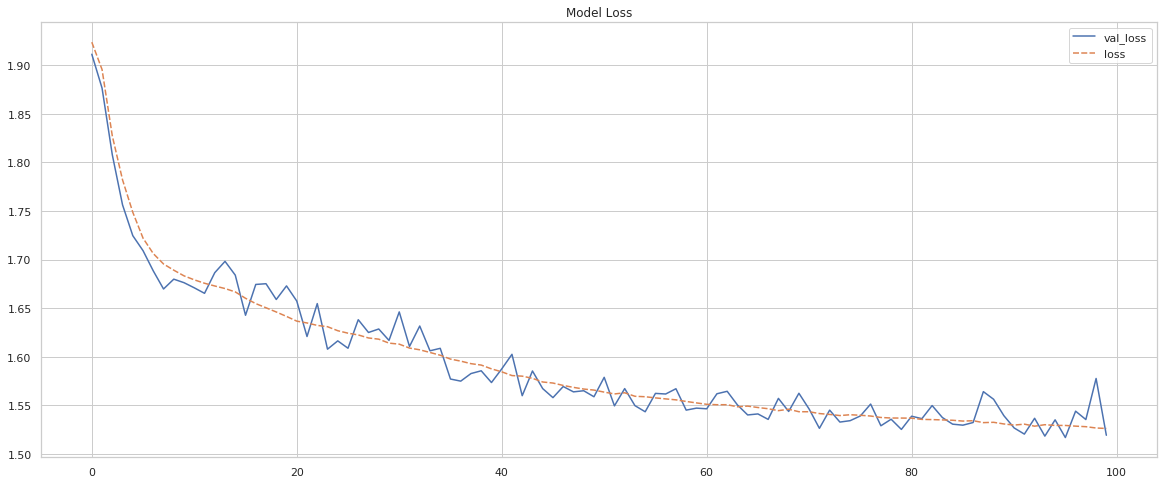

In [15]:
history_pd = pd.DataFrame.from_dict(history.history)
plt.figure(figsize=(20, 8))
ax = plt.axes()
ax.set_title('Model Loss')
sns.lineplot(data=history_pd)
plt.show()

#### Model evaluation

In [16]:
train_pred = model.predict_classes(X_train)
val_pred = model.predict_classes(X_val)
Y_train_max = np.argmax(Y_train, axis=1)
Y_val_max = np.argmax(Y_val, axis=1)

print('Train accuracy', accuracy_score(Y_train_max, train_pred))
print('Validation accuracy', accuracy_score(Y_val_max, val_pred))

Train accuracy 0.43207327742568763
Validation accuracy 0.43103301111751274


#### Model confusion matrix

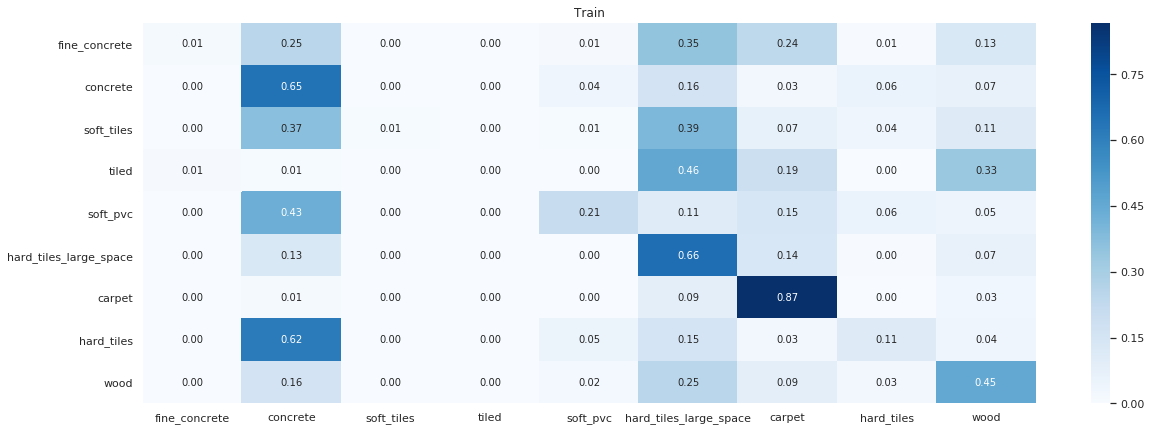

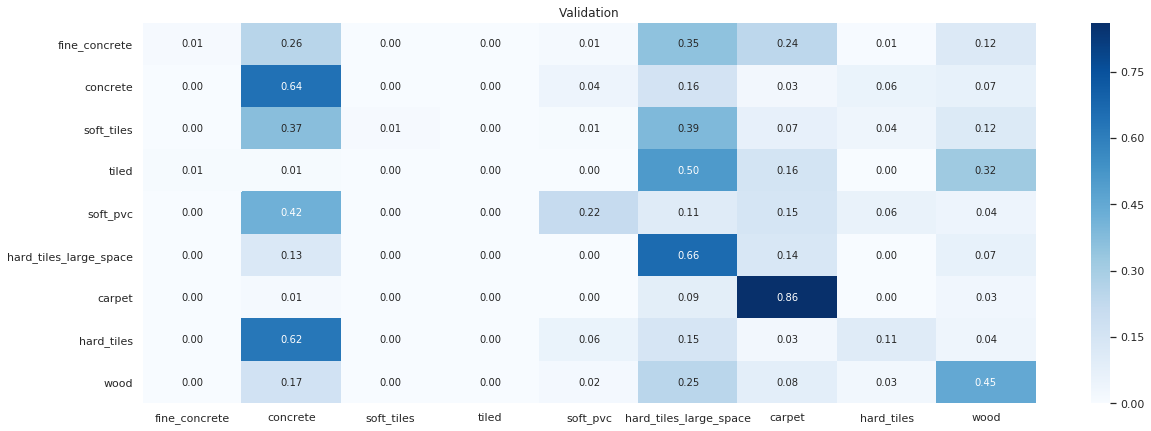

In [17]:
cnf_matrix = confusion_matrix(Y_train_max, train_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Train')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

cnf_matrix = confusion_matrix(Y_val_max, val_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Validation')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

### Test predictions

In [ ]:
predictions = model.predict_classes(X_test)
test['surface'] = le.inverse_transform(predictions)
df = test[['series_id', 'surface']]
df = df.groupby('series_id', as_index=False).agg(lambda x:x.value_counts().index[0])
df.to_csv('submission.csv', index=False)
df.head(10)